# Question 2: Moons Dataset & Regularization

For this question, I have implemented the following things:

1. Generated a custom `make_moons`dataset without using `sklearn`.
2. Trained and compared the following models:
   - MLP with early stopping (patience = 50)
   - MLP with L1 regularization
   - MLP with L2 regularization
   - Logistic regression with polynomial features

---

#### Required libraries:

In [1]:
import torch
from torch.backends import mps
from torch import nn, device
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import math
import matplotlib.pyplot as plt

#### Random seed and other training hyperparameters:

In [2]:
seed = 1337
train = 500
test = 500
split_val = 0.2
noises = {"low": 0.1, "med": 0.2, "high": 0.3}
hidden_size = 32
batch_size = 64
lr = 1e-3
max_epochs = 2000
patience = 50

#### Use GPU if available, otherwise fallback to CPU (only works for apple silicon):

In [3]:
if mps.is_available():
    device = device("mps")
else:
    device = device("cpu")

print(f"Using device: {device}")

Using device: mps


---

#### $\lambda$ values for L1 and L2 regularizations:

In [4]:
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]

#### Set random seed for NumPy and PyTorch:

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [6]:
set_seed(seed)

#### Generate the interleaving half-circles with controllable noise:

In [7]:
def make_moons_custom(n_samples: int = 500, noise: float = 0.2, random_state: int = seed):
    rng = np.random.RandomState(random_state)
    n_half = n_samples // 2
    
    # class 0
    t0 = rng.uniform(0, math.pi, n_half)
    x0 = np.stack([np.cos(t0), np.sin(t0)], axis=1)
    
    # class 1 (shifted and flipped)
    t1 = rng.uniform(0, math.pi, n_samples - n_half)
    x1 = np.stack([1 - np.cos(t1), -np.sin(t1) + 0.5], axis=1)
    
    X = np.vstack([x0, x1])
    y = np.hstack([np.zeros(n_half, dtype=int), np.ones(n_samples - n_half, dtype=int)])
    X += rng.normal(scale=noise, size=X.shape)
    
    return X, y

#### Generate three different datasets with low, medium and high noise:

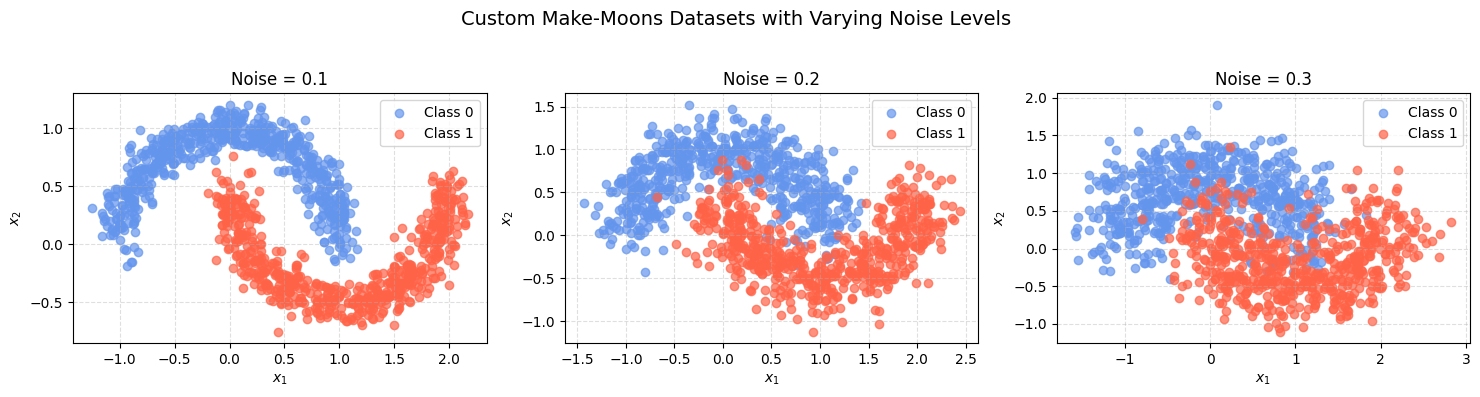

In [8]:
datasets = {}

for key, val in noises.items():
    X_all, y_all = make_moons_custom(n_samples = train + test + 200, noise = val, random_state = seed + int(val * 1000))
    datasets[key] = (X_all, y_all)

fig, axes = plt.subplots(1, 3, figsize = (15, 4))

for ax, (key, (X, y)) in zip(axes, datasets.items()):
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color='cornflowerblue', label='Class 0', alpha=0.7)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color='tomato', label='Class 1', alpha=0.7)
    ax.set_title(f"Noise = {noises[key]}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()

plt.suptitle("Custom Make-Moons Datasets with Varying Noise Levels", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
#### Generate the train, validation, and test split and standardize using training statistics:

In [9]:
def train_val_test_split(X, y, train_size=350, test_size=150, val_frac=0.2, seed=seed):
    # train-test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    # split validation from train
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_frac, random_state=seed, stratify=y_train_full
    )

    # standardize using train stats
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0, ddof=0)
    std[std == 0] = 1.0
    X_train_s = (X_train - mean) / std
    X_val_s = (X_val - mean) / std
    X_test_s = (X_test - mean) / std

    scaler = {'mean': mean, 'std': std}
    return {
        'X_train': X_train_s, 'y_train': y_train,
        'X_val': X_val_s, 'y_val': y_val,
        'X_test': X_test_s, 'y_test': y_test,
        'scaler': scaler
    }

#### Plot the pre-processed datasets:

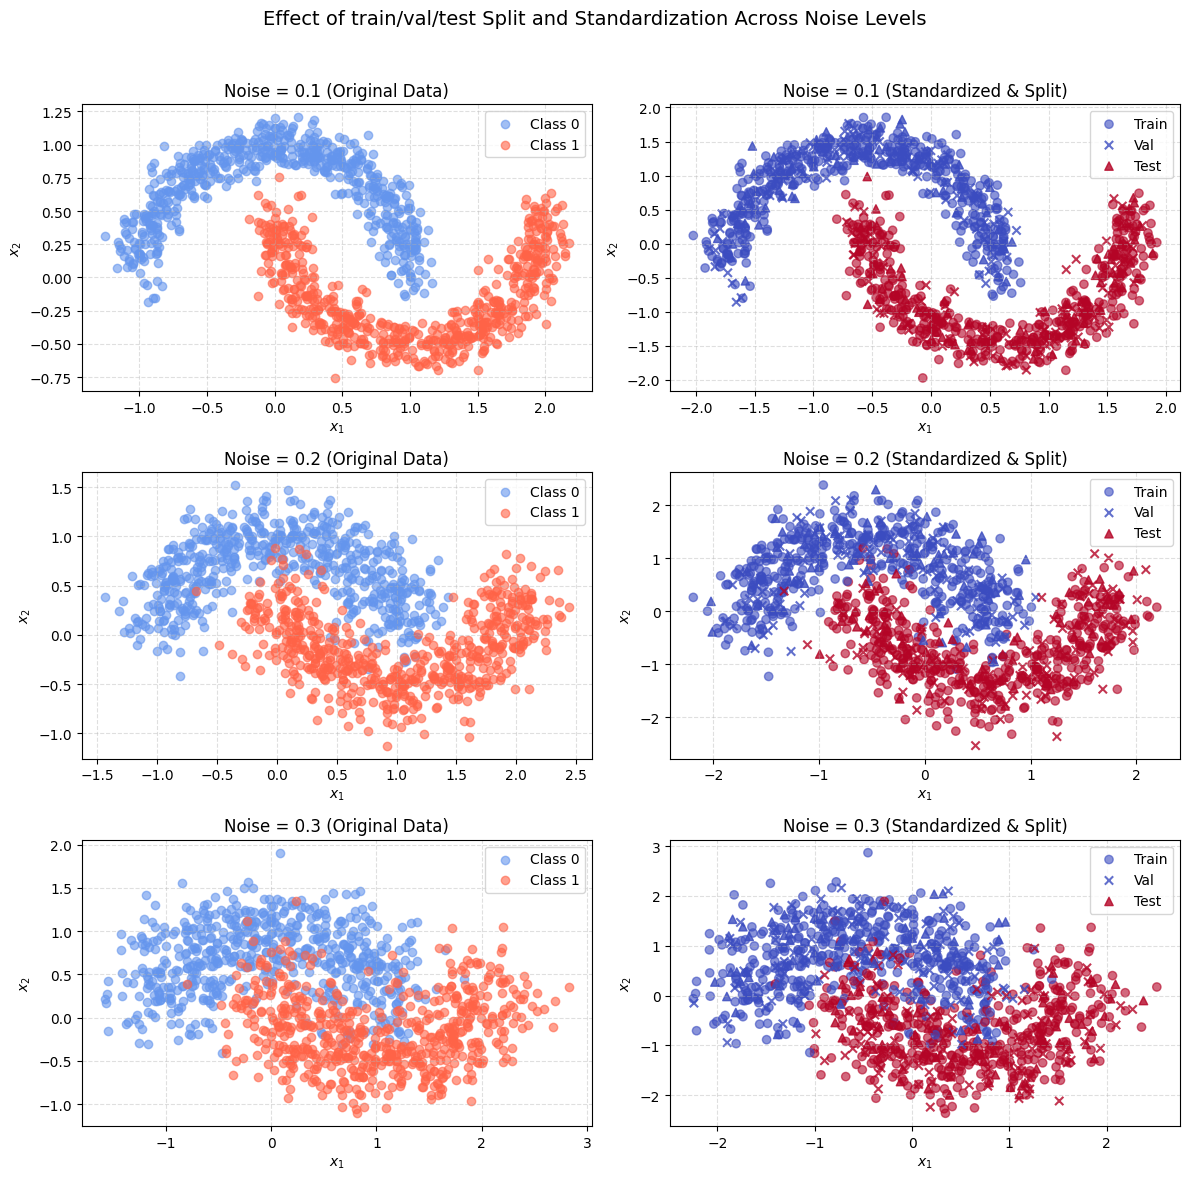

In [10]:
fig, axes = plt.subplots(len(noises), 2, figsize=(12, 12))
fig.suptitle("Effect of train/val/test Split and Standardization Across Noise Levels", fontsize=14)

for i, (key, noise) in enumerate(noises.items()):
    X, y = datasets[key]
    splits = train_val_test_split(X, y)
    X_train, y_train = splits['X_train'], splits['y_train']
    X_val, y_val = splits['X_val'], splits['y_val']
    X_test, y_test = splits['X_test'], splits['y_test']
    
    # original data
    ax1 = axes[i, 0]
    ax1.scatter(X[y == 0, 0], X[y == 0, 1], color='cornflowerblue', label='Class 0', alpha=0.6)
    ax1.scatter(X[y == 1, 0], X[y == 1, 1], color='tomato', label='Class 1', alpha=0.6)
    ax1.set_title(f"Noise = {noise} (Original Data)")
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.4)
    
    # standardized and split
    ax2 = axes[i, 1]
    ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', label='Train', alpha=0.6)
    ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='coolwarm', marker='x', label='Val', alpha=0.8)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', marker='^', label='Test', alpha=0.8)
    ax2.set_title(f"Noise = {noise} (Standardized & Split)")
    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("$x_2$")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---
#### A simple 2-layer MLP with ReLU activation for binary classification:

In [11]:
class SimpleMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)

#### Function to count the number of trainable parameters in the model:

In [12]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Function to train the MLP model, with L1/L2 regularization and early stopping:

In [13]:
def train_mlp(model: nn.Module, train_data, val_data, lr=lr, weight_decay=0.0, l1_lambda=0.0, max_epochs=max_epochs, patience=patience, device=device):
    model = model.to(device)
    X_train, y_train = train_data
    X_val, y_val = val_data

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()),
                              batch_size=batch_size, shuffle=True)

    best_val_auc = -1.0
    best_state = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_auc': []}
    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            if l1_lambda > 0:
                l1 = 0.0
                for p in model.parameters():
                    l1 = l1 + p.abs().sum()
                loss = loss + l1_lambda * l1
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_train_loss = running_loss / len(train_loader.dataset)

        # validation AUROC
        model.eval()
        with torch.no_grad():
            Xv = torch.from_numpy(X_val).float().to(device)
            logits_v = model(Xv).cpu().numpy()
            probs_v = 1 / (1 + np.exp(-logits_v))
            try:
                val_auc = roc_auc_score(y_val, probs_v)
            except ValueError:
                val_auc = 0.5
        history['train_loss'].append(avg_train_loss)
        history['val_auc'].append(val_auc)

        # early stopping on val_auc
        if val_auc > best_val_auc + 1e-8:
            best_val_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}, best_val_auc={best_val_auc:.4f}")
                break

    return {'best_state': best_state, 'history': history, 'best_val_auc': best_val_auc}

#### Function to generate predictions (probabilities) from the trained MLP model:

In [14]:
def predict_mlp(model: nn.Module, X: np.ndarray, state_dict=None, device=device) -> np.ndarray:
    if state_dict:
        model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).float().to(device)).cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))
    return probs

#### Function to compute layer-wise sparsity of the trained MLP model weights:

In [15]:
def layerwise_sparsity(model_state, threshold=1e-6):
    sparsity = {}
    
    for k, v in model_state.items():
        if 'weight' in k:
            arr = v.numpy()
            frac_zero = float((np.abs(arr) <= threshold).sum()) / arr.size
            sparsity[k] = frac_zero
    return sparsity

#### Function to plot decision boundaries for trained models:

In [16]:
def plot_decision_boundaries(models_info, X, y, scaler, titles):
    n = len(models_info)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False)
    
    # create grid in original input space and standardize
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # standardize with train stats
    mean = scaler['mean']
    std = scaler['std']
    grid_s = (grid - mean) / std

    for i, info in enumerate(models_info):
        ax = axs[0, i]
        if info['type'] == 'mlp':
            probs = predict_mlp(info['model'], grid_s, state_dict=info['state'])
        elif info['type'] == 'logreg':
            # for logreg, grid should be transformed by poly
            poly = info['poly']
            grid_poly = poly.transform(grid_s)
            probs = info['model'].predict_proba(grid_poly)[:,1]
        else:
            raise ValueError("Unknown model type")
        Z = probs.reshape(xx.shape)
        ax.contourf(xx, yy, Z, levels=50, cmap='RdBu', alpha=0.6)
        ax.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=20)
        ax.set_title(titles[i])
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

---

#### Train the MLP with early stopping:

In [17]:
def train_baseline_mlp(split):
    model = SimpleMLP()
    result = train_mlp(model, (split['X_train'], split['y_train']), (split['X_val'], split['y_val']))
    param_count = count_parameters(model)
    
    print(f"Baseline MLP trained, Best Val AUC: {result['best_val_auc']:.4f}")
    return model, result['best_state'], param_count

#### Perform L1 regularization grid search and select best $\lambda$:

In [18]:
def grid_search_l1(split):
    best = {'val_auc': -1, 'state': None, 'lambda': None}
    results = []

    for l1 in l1_grid:
        model = SimpleMLP()
        res = train_mlp(
            model,
            (split['X_train'], split['y_train']),
            (split['X_val'], split['y_val']),
            l1_lambda=l1
        )
        results.append((l1, res['best_val_auc']))
        if res['best_val_auc'] > best['val_auc']:
            best = {'val_auc': res['best_val_auc'], 'state': res['best_state'], 'lambda': l1}
        print(f"L1 = {l1:.0e}, Val AUC={res['best_val_auc']:.4f}")
    print(f"Best L1 λ = {best['lambda']} (Val AUC={best['val_auc']:.4f})")
    
    return best, results

#### Perform L2 regularization grid search and select best weight decay:

In [19]:
def grid_search_l2(split):
    best = {'val_auc': -1, 'state': None, 'wd': None}
    results = []

    for wd in l2_grid:
        model = SimpleMLP()
        res = train_mlp(
            model,
            (split['X_train'], split['y_train']),
            (split['X_val'], split['y_val']),
            weight_decay=wd
        )
        results.append((wd, res['best_val_auc']))
        if res['best_val_auc'] > best['val_auc']:
            best = {'val_auc': res['best_val_auc'], 'state': res['best_state'], 'wd': wd}
        print(f"L2 wd = {wd:.0e}, Val AUC={res['best_val_auc']:.4f}")
    print(f"Best L2 wd = {best['wd']} (Val AUC={best['val_auc']:.4f})")
    return best, results

#### Train polynomial ($x^2$) logistic regression:

In [20]:
def train_polynomial_logreg(split):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(split['X_train'])
    X_val_poly = poly.transform(split['X_val'])
    
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train_poly, split['y_train'])
    
    val_pred = logreg.predict_proba(X_val_poly)[:, 1]
    val_auc = roc_auc_score(split['y_val'], val_pred)
    
    param_count = logreg.coef_.size + logreg.intercept_.size
    print(f"Polynomial Logistic Regression trained, Val AUC: {val_auc:.4f}")
    return logreg, poly, param_count

#### Visualize decision boundaries for all trained models:

In [21]:
def plot_all_models(models_info, split):
    titles = [m['name'] for m in models_info]
    plot_decision_boundaries(
        models_info,
        split['X_train'],
        split['y_train'],
        split['scaler'],
        titles
    )

#### Evaluate all models on test sets with different noise levels:

In [22]:
def evaluate_models(datasets, split, trained_models):
    eval_table = []
    for noise_key, (X_all, y_all) in datasets.items():
        data = train_val_test_split(X_all, y_all, seed=seed)
        X_test_s, y_test = data['X_test'], data['y_test']

        row = {'noise': noise_key}
        for name, model_info in trained_models.items():
            if name == 'logreg':
                X_poly = model_info['poly'].transform(X_test_s)
                probs = model_info['model'].predict_proba(X_poly)[:, 1]
            else:
                probs = predict_mlp(SimpleMLP(), X_test_s, state_dict=model_info['state'])
            auc = roc_auc_score(y_test, probs)
            row[name] = auc
        eval_table.append(row)
    return pd.DataFrame(eval_table), {k: count_parameters(SimpleMLP()) for k in ['mlp', 'l1', 'l2']}

#### Display final evaluation results and parameter counts:

In [23]:
def summarize_results(eval_table, param_counts):
    display(eval_table)

    print()
    print("Parameter counts:")
    
    for name, count in param_counts.items():
        print(f"{name}: {count}")

---
#### Split the default noise dataset OR apply class imbalance to training data:

In [24]:
imbalance = False

if not imbalance:
    default_noise = 0.2
    default_key = None
    for key, val in noises.items():
        if abs(val - default_noise) < 1e-6:
            default_key = key
            break
            
    X_all_def, y_all_def = datasets[default_key]
    split = train_val_test_split(X_all_def, y_all_def, train_size=train, test_size=test, val_frac=split_val, seed=seed)
else:
    rng = np.random.RandomState(seed)
    X_train, y_train = split['X_train'], split['y_train']
    
    y_train = (y_train > 0.5).astype(int)
    
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]
    
    print(f"Before imbalance: {len(neg_idx)} zeros, {len(pos_idx)} ones")
    
    rng.shuffle(pos_idx)
    n_keep = int(0.3 * len(pos_idx))
    keep_idx = np.concatenate([neg_idx, pos_idx[:n_keep]])
    rng.shuffle(keep_idx)
    
    split['X_train'] = X_train[keep_idx]
    split['y_train'] = y_train[keep_idx]
    
    unique, counts = np.unique(split['y_train'], return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Applied 70:30 imbalance: {len(neg_idx)} zeros, {n_keep} ones")

#### Train baseline MLP model with early stopping:

In [25]:
mlp_model, mlp_state, mlp_params = train_baseline_mlp(split)

Early stopping at epoch 334, best_val_auc=0.9947
Baseline MLP trained, Best Val AUC: 0.9947


#### Perform grid search over $\ell_1$ regularization strengths:

In [26]:
best_l1, l1_results = grid_search_l1(split)

Early stopping at epoch 276, best_val_auc=0.9939
L1 = 1e-06, Val AUC=0.9939
Early stopping at epoch 53, best_val_auc=0.9729
L1 = 3e-06, Val AUC=0.9729
Early stopping at epoch 52, best_val_auc=0.9694
L1 = 1e-05, Val AUC=0.9694
Early stopping at epoch 524, best_val_auc=0.9961
L1 = 3e-05, Val AUC=0.9961
Early stopping at epoch 431, best_val_auc=0.9947
L1 = 1e-04, Val AUC=0.9947
Early stopping at epoch 395, best_val_auc=0.9945
L1 = 3e-04, Val AUC=0.9945
Best L1 λ = 3e-05 (Val AUC=0.9961)


#### Perform grid search over $\ell_2$ (weight decay) values:

In [27]:
best_l2, l2_results = grid_search_l2(split)

Early stopping at epoch 328, best_val_auc=0.9947
L2 wd = 1e-06, Val AUC=0.9947
Early stopping at epoch 355, best_val_auc=0.9945
L2 wd = 3e-06, Val AUC=0.9945
Early stopping at epoch 307, best_val_auc=0.9945
L2 wd = 1e-05, Val AUC=0.9945
Early stopping at epoch 386, best_val_auc=0.9949
L2 wd = 3e-05, Val AUC=0.9949
Early stopping at epoch 408, best_val_auc=0.9953
L2 wd = 1e-04, Val AUC=0.9953
Early stopping at epoch 343, best_val_auc=0.9947
L2 wd = 3e-04, Val AUC=0.9947
Best L2 wd = 0.0001 (Val AUC=0.9953)


#### Train logistic regression with polynomial ($x^2$) features:

In [28]:
logreg_model, poly, logreg_params = train_polynomial_logreg(split)

Polynomial Logistic Regression trained, Val AUC: 0.9598


---
#### Plot decision boundaries and evaluate models:

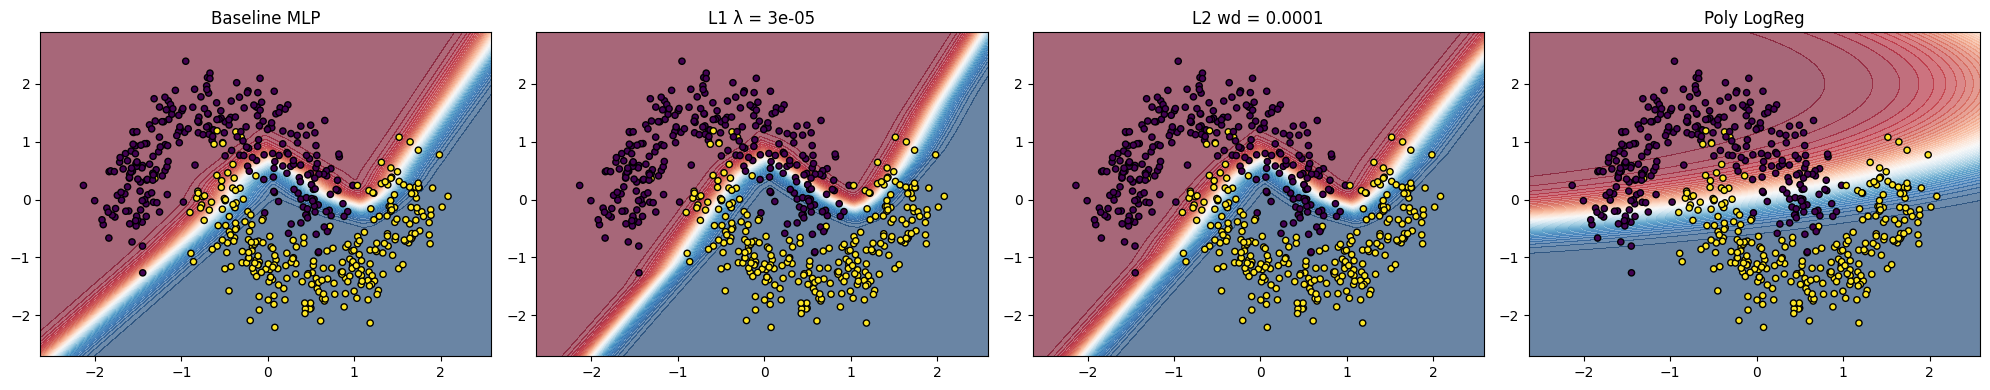

In [29]:
models_info = [
    {'name': 'Baseline MLP', 'type': 'mlp', 'model': mlp_model, 'state': mlp_state},
    {'name': f"L1 λ = {best_l1['lambda']}", 'type': 'mlp', 'model': SimpleMLP(), 'state': best_l1['state']},
    {'name': f"L2 wd = {best_l2['wd']}", 'type': 'mlp', 'model': SimpleMLP(), 'state': best_l2['state']},
    {'name': 'Poly LogReg', 'type': 'logreg', 'model': logreg_model, 'poly': poly},
]

plot_all_models(models_info, split)

In [30]:
trained_models = {
    'mlp': {'state': mlp_state},
    'l1': {'state': best_l1['state']},
    'l2': {'state': best_l2['state']},
    'logreg': {'model': logreg_model, 'poly': poly},
}

eval_table, param_counts = evaluate_models(datasets, split, trained_models)
summarize_results(eval_table, param_counts)

,noise,mlp,l1,l2,logreg
0,low,0.999822,1.000000,0.999822,0.969422
1,med,0.990044,0.990933,0.991467,0.937244
2,high,0.990578,0.990756,0.990222,0.948622



Parameter counts:
mlp: 129
l1: 129
l2: 129
